In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import PIL
import cv2
from PIL import Image # This line already imports Image correctly.
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
hashbanger_ph2_resized2_path = kagglehub.dataset_download('hashbanger/ph2-resized2')
print(hashbanger_ph2_resized2_path)
print('Data source import complete.')

!cd /root/.cache/kagglehub/datasets/hashbanger/ph2-resized2/versions/1 && ls

100%|██████████| 48.9M/48.9M [00:02<00:00, 21.0MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/hashbanger/ph2-resized2/versions/1
Data source import complete.
ph2_resized2  trainx  trainy


In [ ]:
def load_data(image_dir, mask_dir):
    images, masks = [], []
    file_names = sorted(os.listdir(image_dir))
    for file_name in file_names:
        image_path = os.path.join(image_dir, file_name)
        mask_file_name = file_name.replace("X_img", "Y_img")
        mask_path = os.path.join(mask_dir, mask_file_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180))
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(180, 180), color_mode='grayscale')
            images.append(tf.keras.preprocessing.image.img_to_array(image) / 255.0)
            masks.append(tf.keras.preprocessing.image.img_to_array(mask) / 255.0)
        else:
            print(f"Eksik dosya: {file_name} veya {mask_file_name}")
    return np.array(images), np.array(masks)

In [ ]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/ph2/trainx_rs"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/ph2/trainy_rs"
X, Y = load_data(image_dir, mask_dir)

Eksik dosya: X_img_113.jpg veya Y_img_113.jpg


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (160, 180, 180, 3)
x_test shape: (40, 180, 180, 3)
y_train shape: (160, 180, 180, 1)
y_test shape: (40, 180, 180, 1)


In [ ]:
def unet_model():
    inputs = layers.Input((180, 180, 3))

    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    u2 = layers.UpSampling2D((2, 2))(p2)
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u3 = layers.UpSampling2D((2, 2))(c3)
    u3 = layers.Concatenate()([u3, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 180, 180, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 180, 180, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 90, 90, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 90, 90, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 90, 90, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 45, 45, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 90, 90, 64)     │              0 │ max_pooling2d_1[0][0]  │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 90, 90, 128)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 90, 90, 64)     │         73,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 90, 90, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 180, 180, 64)   │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 180, 180, 96)   │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 180, 180, 32)   │         27,680 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 180, 180, 32)   │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 180, 180, 1)    │             33 │ conv2d_7[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 213,249 (833.00 KB)

 Trainable params: 213,249 (833.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), batch_size=8)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - accuracy: 0.6850 - loss: 0.5922 - val_accuracy: 0.6485 - val_loss: 0.5059
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.6702 - loss: 0.5189 - val_accuracy: 0.7420 - val_loss: 0.4774
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8032 - loss: 0.4511 - val_accuracy: 0.8196 - val_loss: 0.4458
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8430 - loss: 0.4278 - val_accuracy: 0.7762 - val_loss: 0.4356
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8174 - loss: 0.4042 - val_accuracy: 0.7023 - val_loss: 0.4956
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7913 - loss: 0.4648 - val_accuracy: 0.8590 - val_loss: 0.3411
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8690 - loss: 0.3297 - val_accuracy: 0.7856 - val_loss: 0.4208
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8255 - loss: 0.4100 - val_accuracy: 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/unet_model1.keras')
print("Model kaydedildi.")

Model kaydedildi.


In [ ]:

def morf(image):

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


    # 3. Median Blur ile gürültüyü azalt
    blurred_image = cv2.medianBlur(image, 9)


    # 4. Adaptive Threshold ile binary görüntü oluştur
    binary_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 5
    )


    # 5. Konvolüsyon ile Gaussian Blur (Yumuşatma)
    kernel = np.ones((5, 5), np.float32) / 25  # 5x5 boyutunda ortalama kernel
    gaussian_blurred = cv2.filter2D(binary_image, -1, kernel)  # Konvolüsyon ile Gaussian Blur


    # 6. Morfolojik işlemler: Erosion ve Dilation (gürültü temizleme)
    kernel1 = np.ones((5, 5), np.uint8)  # 5x5 boyutunda bir kernel oluştur

    # Erosion işlemi
    eroded_image = cv2.erode(gaussian_blurred, kernel1, iterations=1)


    # Dilation işlemi
    dilated_image = cv2.dilate(eroded_image, kernel1, iterations=1)


    # 7. Küçük konturları silme
    min_area = 260  # Konturun minimum alanı (piksel cinsinden)

    # Kenar tespit yöntemleri
    canny_edges = cv2.Canny(blurred_image, threshold1=105, threshold2=105)


    # Konturları bul
    contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Küçük konturları çıkar
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) >= min_area]

    # 8. Filtrelenmiş konturları çiz ve içini doldur
    output_image = np.zeros_like(image)

    for contour in filtered_contours:
        cv2.drawContours(output_image, [contour], -1, (255), thickness=cv2.FILLED)  # Konturların içini doldur

    # 9. Sonuç görüntüsünü kaydet ve göster
    #cv2.imwrite('ikinci_gorsel_konvolusyonlu.png', output_image)
    return output_image


In [ ]:
def display_results(model, X_samples, Y_samples, threshold=0.6):
    predictions = model.predict(X_samples)
    plt.figure(figsize=(15, 5))

    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.title("Orijinal")
        plt.imshow(X_samples[i])
        plt.axis('off')

        plt.subplot(3, 3, i * 3 + 2)
        plt.title("Ground Truth")
        plt.imshow(Y_samples[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Eşikleme işlemi
        binary_prediction = (predictions[i] > threshold).astype(np.uint8)
        plt.subplot(3, 3, i * 3 + 3)
        plt.title("Tahmin (Binary)")
        plt.imshow(binary_prediction.squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
testpath = "/content/drive/MyDrive/Colab Notebooks/ph2/testx_rs"

In [ ]:
from tensorflow.keras.preprocessing import image # Import image functions

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Kayıp: {loss:.4f}, Test Doğruluk: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9391 - loss: 0.2737
Test Kayıp: 0.2834, Test Doğruluk: 0.9389


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


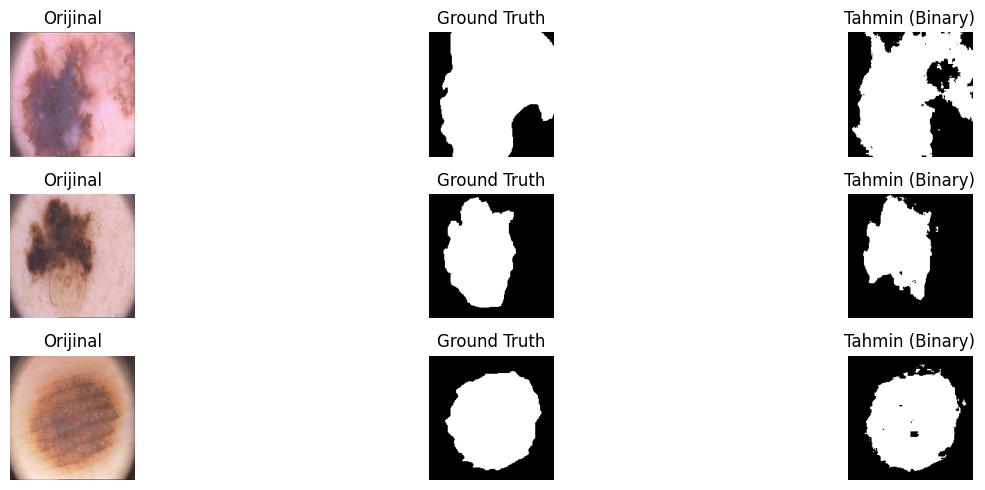

In [ ]:
display_results(model, x_test ,y_test)

In [ ]:
# F1 Skorunu Hesaplama Fonksiyonu
def calculate_f1_score(model, X_test, Y_test, threshold=0.4):
    predictions = model.predict(X_test)
    binary_predictions = (predictions > threshold).astype(np.uint8)
    f1 = f1_score(Y_test.flatten(), binary_predictions.flatten())
    print(f"F1 Skoru: {f1:.4f}")
calculate_f1_score(model, x_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
F1 Skoru: 0.9129
